# Day 1: Choose Pattern & Algorithm

Hough Circle Transform is a feature extraction approach used for detecting circles in images. It is based on mapping edge points of the image to the parameter space, which is called the Hough space. The Hough space represents potential circle parameters: center coordinates (x, y) and radius (r). For each edge point, votes are accumulated in an accumulator array in this parameter space for each possible circle (center and radius-defined) which can pass through the point. Peaks of the accumulator array are high vote concentrations and are likely to be the actual parameters of circles in the original image.

## Custom Implementation Steps:

The algorithm is divided into preprocessing and the main Hough transform steps:

**Step 1: Preprocessing**
This step processes the image to circle detection.

*   **Step 1a: Grayscale Conversion:** The input color image is transformed into a grayscale image of a single channel. The Hough algorithm, by its nature, accepts intensity values to operate on.
*   **Step 1b: Noise Reduction (Blurring):** Grayscale image blurring using a Median blur with a specified kernel size (`blur_ksize`). This is used to reduce noise (e.g., salt-and-pepper noise) that otherwise would lead to spurious edges and false votes in the accumulator. A greater `blur_ksize` will blur more but can conceal small circles.

**Step 2: Custom Hough Circle Detection**
This stage carries out the real detection of circles using the preprocessed image.

*   **Step 2a: Edge Detection and Gradient Calculation:**
*   The Canny edge detector is applied to the blurred image to find possible edge pixels on circle borders. It employs two thresholds: a high threshold (`p1`) to trigger edge curves and a low threshold (typically `p1`/2, named `p2` in the code) to continue them. The stronger edges (greater than `p1`) are identified first, and weaker edges connected to them (greater than the lower threshold) are added.
*   Sobel operator is used to find the gradient (direction and magnitude) of intensity change at each edge pixel. The direction of the gradient is perpendicular to the edge and in the direction of the potential center of a circle that intersects the edge point.

*   **Step 2b: Accumulator Voting:**
*   A 3D accumulator array is constructed, which represents the Hough space. Its dimensions are equal to the possible x-coordinates, y-coordinates of the circle centers, and the possible radii (`minR` to `maxR`).
*   The `dp` argument controls the resolution of the accumulator relative to the input image. `dp=1` means the accumulator resolution matches the input image resolution. `dp=2` means the accumulator resolution is half width and height. Raising the value of `dp` conserves memory and computation but decreases the precision in determining circle centers.
*   For each edge point discovered in Step 2a, and for each possible radius `r` within the range (`minR` to `maxR`), potential center points (`a`, `b`) are calculated along the direction of the gradient (in both positive and negative directions of the edge point). `minR` and `maxR` specify the expected range of circle radii to search for.
*   Votes are stored into the respective `(r, b, a)` bins in the accumulator array. The bins associated with accurate circle parameters will contain many votes.

*   **Step 2c: Peak Detection and Filtering:**
*   The accumulator array is queried for bins (peaks) whose vote count is higher than a specified `acc_thresh` (accumulator threshold). This is the threshold on the number of edge points that must vote for a circle candidate in order for it to be accepted. A higher threshold will result in fewer, but potentially more robust detections.
*   The peaks `(r_idx, y_acc, x_acc)` are translated back to image-space coordinates `(x_center, y_center, radius)`.
    *   The candidates are sorted by their vote strength (i.e., how many times each peak voted for a position).
*   Filtering step is carried out according to `minDist`: if multiple candidate circles with centers at distances within `minDist` pixels are found, only the highest vote (best evidence) one is kept and weaker surrounding detections are eliminated. This prevents the detection of multiple concentric or overlapping circles of the same object.

**Output:** Final output is a list (NumPy array) of detected circles, represented by their center (x, y) and radius (r) coordinates. Edge map, accumulator array, and others are also calculated and can be plotted.

## Parameters Explained:

*   `blur_ksize`: (Preprocessing) Kernel size in Median blur filtering (must be odd). Large values increase blurring.
*   `dp`: (Accumulator) Inverse of accumulator resolution divided by image resolution. `1` = equal resolution, `2` = half resolution.
*   `minDist`: (Filtering) Minimum distance between centers of detected circles. Suppresses weaker, nearby circles.
*   `p1`: (Edge Detection) Higher threshold of Canny edge detector.
*   `acc_thresh`: (Peak Detection) Accumulator vote threshold. Circles with votes greater than this threshold are returned.
*   `minR`: (Voting) Minimum radius for circles to find.
*   `maxR`: (Voting) Maximum radius for circles to find.


Created dummy image with 5 circles
Step 1a: Converted image to grayscale.
Step 1b: Applied Median blur with kernel size 5.
------------------------------
Starting Custom Hough Circle Detection
Parameters: dp=1.0, minDist=40, canny1=150, canny2=75, acc_thresh=10, minR=20, maxR=60
Step 2a: Applying Canny edge detection (Thresholds: 75, 150)
Step 2a: Calculating gradients using Sobel.
Step 2a: Found 2365 edge points.
Step 2b: Initialized 3D accumulator with shape: (40, 500, 500) for radii 20 to 59
Step 2b: Starting voting process...
Step 2b: Voting finished
Step 2c: Finding peaks in accumulator with threshold >= 10.
Step 2c: Found 19 potential peaks above threshold.
Step 2c: Filtering peaks with minDist = 40.
Step 2c: Filtered down to 5 circles.
Custom Hough Circle Detection Finished
------------------------------


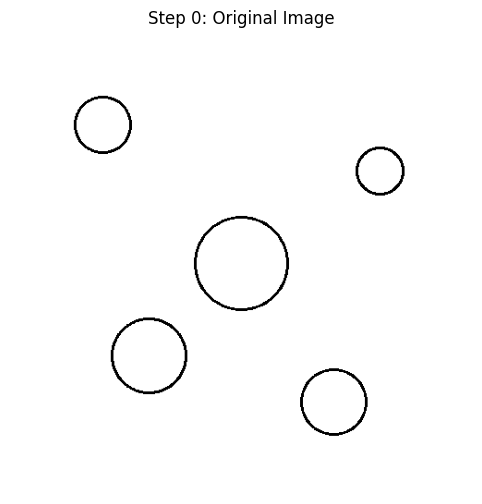

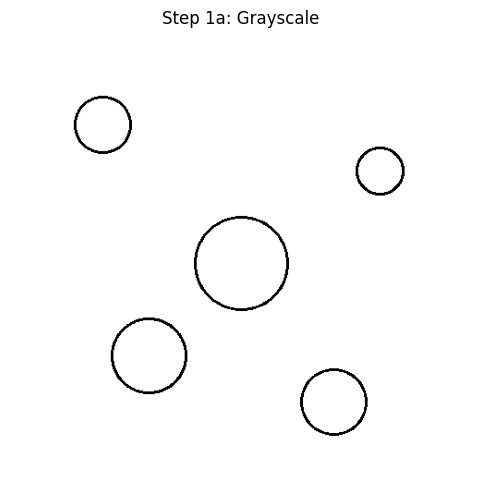

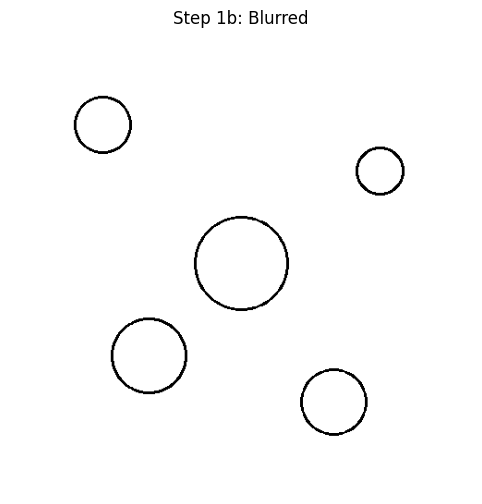

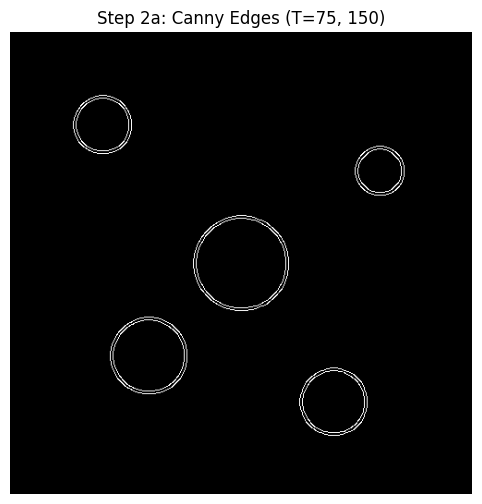

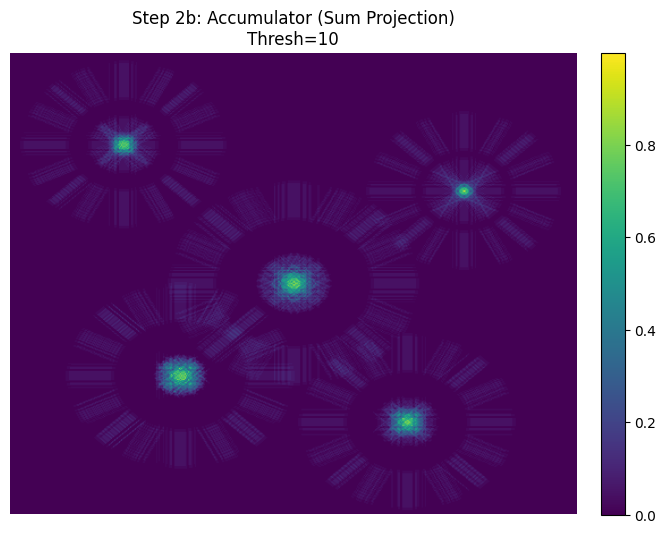

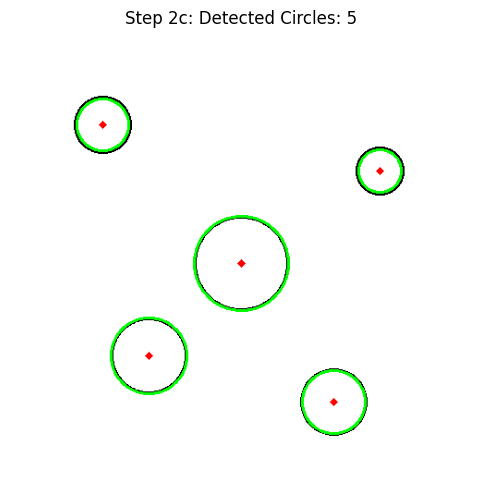

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from collections import defaultdict
from helper_functions import display_results_custom, create_dummy_example


# --- Step 1: Preprocessing (Identical to your original code) ---
def step1_preprocess_for_circles(image, blur_kernel_size=5):
    """Converts to grayscale and applies blur suitable for circle detection."""
    # Step 1a: Grayscale Conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Step 1a: Converted image to grayscale.")

    # Step 1b: Noise Reduction (Median Blur)
    blurred = cv2.medianBlur(gray, blur_kernel_size)  # Kernel size must be odd
    print(f"Step 1b: Applied Median blur with kernel size {blur_kernel_size}.")
    return gray, blurred


# --- Step 2 (Custom Implementation): Hough Circle Detection ---


def step2a_edge_and_gradient(blurred_image, canny_param1, canny_param2):
    """Detect edges using Canny and calculate gradients using Sobel."""
    print(
        f"Step 2a: Applying Canny edge detection (Thresholds: {canny_param2}, {canny_param1})"
    )
    # Note: param1 is the higher threshold for Canny in cv2.HoughCircles
    # param2 is the lower threshold (often param1 / 2)
    edges = cv2.Canny(blurred_image, canny_param2, canny_param1)

    print("Step 2a: Calculating gradients using Sobel.")
    # Calculate gradients using Sobel (use float type for accuracy)
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude and angle
    angle = np.arctan2(sobel_y, sobel_x)  # Range: -pi to +pi

    # Get coordinates of edge pixels
    edge_points = np.argwhere(edges > 0)  # Returns pairs [row, col] (y, x)

    print(f"Step 2a: Found {len(edge_points)} edge points.")
    return edges, edge_points, angle


def step2b_accumulator_voting(
    edge_points, angle_map, minRadius, maxRadius, img_shape, dp=1
):
    """Vote in the 3D Hough accumulator space (x, y, radius)."""
    height, width = img_shape
    # Adjust accumulator resolution based on dp
    acc_height = int(height / dp)
    acc_width = int(width / dp)
    acc_depth = maxRadius - minRadius  # Number of radius bins

    if acc_depth <= 0:
        print("Error: maxRadius must be greater than minRadius.")
        return None, None

    # Initialize accumulator with zeros
    accumulator = np.zeros((acc_depth, acc_height, acc_width), dtype=np.uint32)
    print(
        f"Step 2b: Initialized 3D accumulator with shape: ({acc_depth}, {acc_height}, {acc_width}) for radii {minRadius} to {maxRadius-1}"
    )

    print("Step 2b: Starting voting process...")
    processed_points = 0

    # Define the range of radii
    radius_range = np.arange(minRadius, maxRadius)

    # Vote
    for y, x in edge_points:  # y=row, x=col
        grad_angle = angle_map[y, x]

        # Optimization: calculate cos/sin of the gradient angle once per edge point
        cos_grad = np.cos(grad_angle)
        sin_grad = np.sin(grad_angle)

        for r_idx, r in enumerate(radius_range):
            # Calculate potential center coordinates (a, b) along the gradient direction
            # a = x_center, b = y_center
            a_pos = x + r * cos_grad
            b_pos = y + r * sin_grad
            a_neg = x - r * cos_grad
            b_neg = y - r * sin_grad

            # Map to accumulator coordinates and check bounds
            # Positive direction
            acc_a_pos = int(round(a_pos / dp))
            acc_b_pos = int(round(b_pos / dp))
            if 0 <= acc_a_pos < acc_width and 0 <= acc_b_pos < acc_height:
                accumulator[r_idx, acc_b_pos, acc_a_pos] += 1

            # Negative direction
            acc_a_neg = int(round(a_neg / dp))
            acc_b_neg = int(round(b_neg / dp))
            if 0 <= acc_a_neg < acc_width and 0 <= acc_b_neg < acc_height:
                accumulator[r_idx, acc_b_neg, acc_a_neg] += 1

        processed_points += 1
        if processed_points % 10000 == 0:  # Progress update
            print(f"    Processed {processed_points}/{len(edge_points)} edge points...")

    print(f"Step 2b: Voting finished")
    return accumulator, dp


def step2c_peak_detection_and_filtering(
    accumulator, acc_threshold, minRadius, dp, minDist
):
    """Find peaks in the accumulator and filter them."""
    if accumulator is None:
        return None

    print(f"Step 2c: Finding peaks in accumulator with threshold >= {acc_threshold}.")
    # Find coordinates where accumulator value exceeds the threshold
    # Returns tuple of arrays: (radius_indices, y_indices, x_indices)
    peak_indices = np.argwhere(accumulator >= acc_threshold)

    if len(peak_indices) == 0:
        print("Step 2c: No peaks found above the threshold.")
        return None

    print(f"Step 2c: Found {len(peak_indices)} potential peaks above threshold.")

    # Extract circle parameters (x, y, radius, votes) for each peak
    # Remember to scale back coordinates by dp and add minRadius
    candidate_circles = []
    for r_idx, y_acc, x_acc in peak_indices:
        radius = minRadius + r_idx
        x_center = x_acc * dp
        y_center = y_acc * dp
        votes = accumulator[r_idx, y_acc, x_acc]
        candidate_circles.append([x_center, y_center, radius, votes])

    # Sort candidates by votes (descending) to prioritize stronger circles
    candidate_circles.sort(key=lambda c: c[3], reverse=True)

    # Filter circles based on minDist
    # Keep the circle with the most votes and remove others too close to it
    print(f"Step 2c: Filtering peaks with minDist = {minDist}.")
    final_circles = []
    minDistSq = minDist * minDist  # Use squared distance for efficiency

    for circle in candidate_circles:
        x, y, r, votes = circle
        is_valid = True
        for final_circle in final_circles:
            fx, fy, fr = final_circle  # Already added circles
            distSq = (x - fx) ** 2 + (y - fy) ** 2
            if distSq < minDistSq:
                is_valid = False
                break  # Too close to an existing, stronger circle

        if is_valid:
            final_circles.append([x, y, r])  # Store only x, y, r

    print(f"Step 2c: Filtered down to {len(final_circles)} circles.")

    if not final_circles:
        return None

    # Format output similar to cv2.HoughCircles: [[[x, y, r], [x, y, r], ...]]
    # Use float for centers, int for radius often makes sense, but let's keep float for now
    output_circles = np.array([final_circles], dtype=np.float32)

    return output_circles


# --- Combine steps into the custom Hough function ---
def custom_hough_circles(
    blurred_image,
    dp,
    minDist,
    canny_param1,
    canny_param2,
    minRadius,
    maxRadius,
    accumulator_threshold,
):
    """
    Performs Hough Circle Transform manually.
    Args:
        blurred_image: Input grayscale blurred image.
        dp: Inverse ratio of accumulator resolution to image resolution.
        minDist: Minimum distance between centers of detected circles.
        canny_param1: Higher threshold for Canny edge detector.
        canny_param2: Lower threshold for Canny edge detector.
        minRadius: Minimum circle radius.
        maxRadius: Maximum circle radius.
        accumulator_threshold: Threshold for detecting peaks in the accumulator.
    Returns:
        Numpy array of detected circles [[[x, y, r], ...]] or None.
    """
    print("-" * 30)
    print("Starting Custom Hough Circle Detection")
    print(
        f"Parameters: dp={dp}, minDist={minDist}, canny1={canny_param1}, canny2={canny_param2}, acc_thresh={accumulator_threshold}, minR={minRadius}, maxR={maxRadius}"
    )

    # Step 2a: Edge Detection and Gradient Calculation
    edges, edge_points, angle_map = step2a_edge_and_gradient(
        blurred_image, canny_param1, canny_param2
    )
    if len(edge_points) == 0:
        print("No edge points found, cannot proceed.")
        return None, edges, None  # Return None for circles and accumulator

    # Step 2b: Accumulator Voting
    accumulator, actual_dp = step2b_accumulator_voting(
        edge_points, angle_map, minRadius, maxRadius, blurred_image.shape, dp
    )
    if accumulator is None:
        print("Accumulator creation/voting failed.")
        return None, edges, None

    # Step 2c: Peak Detection and Filtering
    circles = step2c_peak_detection_and_filtering(
        accumulator, accumulator_threshold, minRadius, actual_dp, minDist
    )

    print("Custom Hough Circle Detection Finished")
    print("-" * 30)

    # Return circles, intermediate edge map, and accumulator (for visualization)
    return circles, edges, accumulator


# --- Update the pipeline runner ---
def run_circle_pipeline_custom(
    image,
    blur_ksize=5,
    dp=1,
    minDist=20,
    p1=100,
    p2=50,
    acc_thresh=30,
    minR=10,
    maxR=50,
):
    """Runs the circle detection pipeline using the custom implementation."""
    original_image = image.copy()
    # Step 1: Preprocessing
    gray, blurred = step1_preprocess_for_circles(original_image, blur_ksize)

    # Step 2: Custom Hough Circle Detection
    # Note: cv2 uses param1=Canny High, param2=Accumulator Threshold
    # Our custom function needs Canny Low, Canny High, and Accumulator Threshold separately.
    # Let's map: canny_param1 = p1, canny_param2 = p1/2 (typical Canny setup), acc_thresh = p2
    canny_low = p1 // 2  # Estimate lower Canny threshold
    # Make sure parameters are integers where needed
    circles, edges, accumulator = custom_hough_circles(
        blurred,
        dp=float(dp),
        minDist=int(minDist),
        canny_param1=int(p1),  # Canny High
        canny_param2=int(canny_low),  # Canny Low
        minRadius=int(minR),
        maxRadius=int(maxR),
        accumulator_threshold=int(
            acc_thresh
        ),  # Separate accumulator threshold (was p2)
    )

    results = {
        "original": original_image,
        "grayscale": gray,
        "blurred": blurred,
        "edges": edges,  # Add intermediate edge map
        "accumulator": accumulator,  # Add intermediate accumulator
        "circles": circles,  # The list of detected circle parameters
        "params": {  # Store params used for display
            "dp": dp,
            "minDist": minDist,
            "p1": p1,
            "p2": p2,
            "acc_thresh": acc_thresh,
            "minR": minR,
            "maxR": maxR,
        },
    }
    return results


# --- Tedt the pipeline ---

dummy_image = create_dummy_example()

# Parameters for custom implementation
custom_params = {
    "blur_ksize": 5,
    "dp": 1,
    "minDist": 40,
    "p1": 150,
    "p2": 75,
    "acc_thresh": 10,
    "minR": 20,
    "maxR": 60,
}


dummy_results_custom = run_circle_pipeline_custom(dummy_image, **custom_params)

display_results_custom(dummy_results_custom)

# Day 2: Defining Use Case
**Country Context:** Poland

**Problem Statement:**
Manual counting of blood cells for diagnostic purposes is a long process requiring trained personnel. Professional diagnostic laboratories in Poland are centralized in larger cities, yet a large part of the population live in rural areas. Automation of the process can help improve efficiency and consistency and may help support local health centers in rural towns by having faster diagnostic capabilities, thereby improving access to healthcare. The challenge lies in accurately detecting and counting cells from microscopy images that can vary in quality. 

**Use Case:**
To develop and illustrate the method of automatic detection of circular objects (like red blood cells) as an initial step towards the construction of robust assistance tools. These would be particularly valuable for **Poland**'s regional healthcare centers, especially rural ones, to complement the diagnostic services of specialist urban laboratories. 

**Objectives:**
1. Apply the custom manual Hough Circle Transform to a representative blood cell image.
2. Visualize the intermediate outputs of the custom algorithm (edges, accumulator).
3. Evaluate the success of the algorithm in detecting cells in the chosen image.
4. Discuss the feasibility and limitations of this custom solution for the application, including the possible deployment in different healthcare settings throughout Poland. 

**Relevance (WHY):**
Automation of cell counts enhances diagnostic throughput and consistency. Such is crucial for the proper provision of healthcare, particularly in bridging the potential difference in the availability of diagnostic services between urban centers and rural areas in **Poland**. This study enables an understanding of the algorithmic basis for such automation and how it may benefit healthcare providers in the regions. 

**Image Selection:**
We will be using an open-access image of red blood cells. The image is from Wikipedia and can be accessed here: https://upload.wikimedia.org/wikipedia/commons/1/16/Normal_Adult_Blood_Smear.JPG

**Background Information:**
Complete blood counts (CBC) are among the most common laboratory tests performed around the world, including in **Poland**. Red blood cell counts are a significant component, used in the diagnosis of diseases like anemia. Automating portions of such an analysis through image processing is an area of continued development with the potential to increase the timeliness and availability of diagnostics, especially outside major urban centers. 


Successfully loaded cell image from URL.


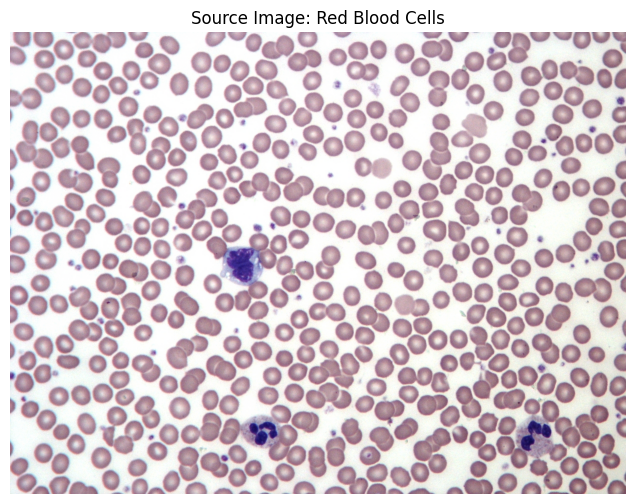

In [2]:
import requests
from helper_functions import display_image


image_url = (
    "https://upload.wikimedia.org/wikipedia/commons/1/16/Normal_Adult_Blood_Smear.JPG"
)
# Wikipedia requires a user agent header to be sent. We send a dummy one.
headers = {
    "User-Agent": "YourAppName/1.0 (your-email@example.com; https://your-website.com)"
}

try:
    # Fetch the image from the URL
    response = requests.get(image_url, headers=headers)
    response.raise_for_status()

    # Read the image data
    image_bytes = BytesIO(response.content)
    image_np = np.frombuffer(image_bytes.read(), np.uint8)

    # Decode the image
    source_image_cells = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    if source_image_cells is None:
        raise ValueError("Image decoding failed.")

    print("Successfully loaded cell image from URL.")
    display_image(source_image_cells, title="Source Image: Red Blood Cells")

except requests.exceptions.RequestException as e:
    print(f"Error fetching image: {e}")
    source_image_cells = None
except Exception as e:
    print(f"Error processing image: {e}")
    source_image_cells = None